In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import modules.deep_model as DeepModel
import modules.model as Model 
import tensorflow as tf
import warnings
import numpy as np
import os

warnings.filterwarnings('ignore')

## C√¥ng vi·ªác 2.2 (Ti·∫øp theo):
* ·ªû ph·∫ßn n√†y, ch√∫ng ta s·∫Ω x√¢y d·ª±ng m·ªôt **Comment sentiment model** b·∫±ng LSTM.
* Ch√∫ng ta bi·∫øt r·∫±ng h·∫°n ch·∫ø c·ªßa RNN l√† n√≥ kh√¥ng th·ªÉ l∆∞u tr·ªØ c√°c th√¥ng tin trong d√†i h·∫°n - RNN ti·∫øn h√†nh l∆∞u tr·ªØ c√°c th√¥ng tin m√† n√≥ h·ªçc ƒë∆∞·ª£c t·ª´ chu·ªïi v√†o c√°c **hidden state** nh∆∞ng khi chu·ªïi ƒë·∫ßu v√†o qu√° d√†i - n√≥ s·∫Ω kh√¥ng th·ªÉ gi·ªØ l·∫°i c√°c th√¥ng tin n√†y do v·∫•n ƒë·ªÅ **gradient-vanishing** [ti√™u bi·∫øn gradient] trong qu√° tr√¨nh backpropagation:<br>
  ![](./images/14.png)
* LSTM ra ƒë·ªùi ƒë·ªÉ kh·∫Øc ph·ª•c gradient-vanishing b·∫±ng m·ªôt c·∫•u tr√∫c ƒë·∫∑c bi·ªát g·ªçi l√† **gate**. Gate s·∫Ω l∆∞u c√°c th√¥ng tin c·ªßa chu·ªïi l·∫°i ƒë·ªìng th·ªùi n√≥ qu·∫£n l√≠ ƒë∆∞·ª£c th√¥ng tin n√†o n√™n x√≥a kh·ªèi b·ªô nh·ªõ v√† th√¥ng tin n√†o c·∫ßn gi·ªØ.
* Gi·∫£ s·ª≠ ch√∫ng ta c√≥ c√¢u: **Giao h√†ng nhanh**. V·ªõi RNN n√≥ d·ªÖ d√†ng d·ª± ƒëo√°n ƒë∆∞·ª£c comment n√†y thu·ªôc class positive. Nh∆∞ng gi·∫£ s·ª≠ ta c√≥ c√¢u d√†i h∆°n: **Giao h√†ng ch·∫≠m "nh∆∞ng" h√†ng ƒë·∫πp - c·∫£m ∆°n shop**. Th√¨ c√¢u h·ªèi ƒë·∫∑t ra l√† l√†m sao RNN c√≥ th·ªÉ l∆∞u tr·ªØ c√°c th√¥ng tin tr∆∞·ªõc t·ª´ **nh∆∞ng** l√† negative word v√† ph√≠a sau l√† positive word. RNN s·∫Ω kh√¥ng th·ªÉ l∆∞u tr·ªØ c√°c th√¥ng tin n√†y do v·∫•n ƒë·ªÅ vanishing-gradient. Nh∆∞ng v·ªõi LSTM n√≥ s·∫Ω gi·∫£m b·ªõt hi·ªán t∆∞·ª£ng n√†y nh·ªù s·ª≠ d·ª•ng m·ªôt c·∫•u tr√∫c l√† LSTM cell. <br>
  ![](./images/15.png)
* L√∫c n√†y, m·ªói LSTM cell s·∫Ω ch·ª©a ba gate l·∫ßn l∆∞·ª£t l√†:
  * **Input gate**: quy·∫øt ƒë·ªãnh th√¥ng tin n√†o c·∫ßn ƒë∆∞·ª£c th√™m v√†o t·ª´ chu·ªïi ƒë·∫ßu v√†o.
  * **Output gate**: quy·∫øt ƒë·ªãnh th√¥ng tin n√†o c·∫ßn ƒë∆∞·ª£c l∆∞u tr·ªØ
  * **Forget gate**: th√¥ng tin n√†o c·∫ßn ƒë∆∞·ª£c lo·∫°i b·ªè.
  
  ![](./images/16.png)

* ·ªû RNN, m·ªôt hidden state ƒë∆∞·ª£c s·ª≠ d·ª•ng cho hai m·ª•c ƒë√≠ch l√† l∆∞u tr·ªØ th√¥ng tin v√† ƒë∆∞a ra d·ª± ƒëo√°n. Tuy nhi√™n ·ªü LSTM n√≥ t√°ch hiddent state th√†nh hai ph·∫ßn l√†:
  * **Cell state**: ƒë√¢y l√† n∆°i l∆∞u gi·ªØ th√¥ng tin.
  * **Hidden state**: d√πng cho vi·ªác d·ª± ƒëo√°n.
* Cell state v√† hidden state chia s·∫ª th√¥ng tin l·∫´n nhau. Nh∆∞ h√¨nh tr√™n ta th·∫•y ƒë·∫ßu v√†o sau khi ƒëi qua hidden state $\rightarrow$ qua c√°c gate $\rightarrow$ ƒë·∫øn cell state.

B√¢y gi·ªù ch√∫ng ta s·∫Ω ti·∫øn h√†nh x√¢y d·ª±ng m·ªôt **Comment sentiment model** s·ª≠ d·ª•ng LSTM c·ªßa TensorFlow.

Load d·ªØ li·ªáu training.

In [3]:
X_train, y_train = Model.loadData("./data/data/train")
X_train = X_train.fillna("")

X_test, y_test = Model.loadData("./data/data/test")
X_test = X_test.fillna("")

display(X_train, y_train)
display(X_test, y_test)


raw_comment  \
0                                      form k ƒëeÃ£p laÃÜÃÅm   
1      AÃÅo RoÃ£ÃÇng thaÃ£ÃÇt suÃõÃ£\nGl nhanh\nChaÃ£ÃÇt luÃõoÃõ...   
2               MaÃÄu tuÃÅi hoÃõi toÃÇÃÅi do voÃõÃÅi aÃânh chuÃ£p   
3                        ChaÃÇÃÅt lieÃ£ÃÇu vaÃâi k oÃÇÃân laÃÜÃÅm   
4      MaÃÉ "maÃÄu ƒëen" hieÃ£ÃÇn leÃÇn aÃÅo maÃÄu ƒëen, coÃÄn ...   
...                                                  ...   
11359  Khi baÃÅn combo ghi 3 ƒëoÃÇi, nhuÃõng nhaÃ£ÃÇn chiÃâ ...   
11360  AÃÅo ƒëeÃ£p, from chuaÃÇÃân. SeÃÉ uÃâng hoÃ£ÃÇ tieÃÇÃÅp aÃ£ !   
11361  ƒêaÃ£ÃÜt maÃÄu traÃÜÃÅng kem thiÃÄ giao maÃÄu xanh ƒëen...   
11362  ƒêoÃÇÃÄ choÃõi tiÃÅ hon.\nShop neÃÇn duÃõÃÄng baÃÅn sp ...   
11363  Son ƒëeÃ£p laÃÜÃÅm nha moÃ£i ng, ƒëaÃÅng ƒëoÃÇÃÄng tieÃÇÃÄ...   

                                       normalize_comment    emoji_decode  
0                                 form khoÃÇng ƒëeÃ£p laÃÜÃÅm                  
1      aÃÅo roÃ£ÃÇng thaÃ£ÃÇt suÃõÃ£ nhanh chaÃ£ÃÇt luÃõoÃõÃ£ng v...                  
2                     maÃÄu tuÃÅi hoÃõi toÃÇÃÅi do aÃânh chuÃ£p                  
3                   chaÃÇÃÅt lieÃ£ÃÇu vaÃâi khoÃÇng oÃÇÃân laÃÜÃÅm                  
4      maÃÉ maÃÄu ƒëen hieÃ£ÃÇn leÃÇn aÃÅo maÃÄu ƒëen coÃÄn maÃÉ...                  
...                                                  ...             ...  
11359  baÃÅn combo ghi ƒëoÃÇi nhuÃõng nhaÃ£ÃÇn chiÃâ ƒëoÃÇi ta...                  
11360         aÃÅo ƒëeÃ£p from chuaÃÇÃân seÃÉ uÃâng hoÃ£ÃÇ tieÃÇÃÅp                  
11361  ƒëaÃ£ÃÜt maÃÄu traÃÜÃÅng kem giao maÃÄu xanh ƒëen giao...  expressionless  
11362  ƒëoÃÇÃÄ choÃõi tiÃÅ hon neÃÇn duÃõÃÄng baÃÅn saÃân phaÃÇÃâ...                  
11363  son ƒëeÃ£p laÃÜÃÅm moÃ£i ƒëaÃÅng ƒëoÃÇÃÄng tieÃÇÃÄn baÃÅt m...                  

[11364 rows x 3 columns]

label
0          0
1          1
2          0
3          0
4          0
...      ...
11359      0
11360      1
11361      0
11362      0
11363      1

[11364 rows x 1 columns]

raw_comment  \
0     Shop baÃÅn haÃÄng kiÃâ quaÃÇÃÅn ƒëaÃÇÃÄy ƒëuÃâ. ChaÃÇÃÅt l...   
1     ƒêaÃ£ÃÜt xl, aÃÅo ghi xl nhuÃõng laÃ£i beÃÅ tiÃÅ teÃ£o ...   
2     KeÃ£p raÃÇÃÅt raÃÇÃÅt ƒëeÃ£p saÃÜn ƒëuÃõoÃõÃ£c giaÃÅ sale h...   
3     K nghiÃÉ aÃÅo ƒëeÃ£p vaÃ£ÃÇy ƒëaÃÇu giao haÃÄng nhanh k...   
4     HoÃÇm nay moÃõÃÅi nhaÃ£ÃÇn ƒëc nhuÃõng nhiÃÄn qua thaÃÇ...   
...                                                 ...   
2837  MiÃÄnh ƒëaÃ£ÃÜt 2 daÃÇy buoÃ£ÃÇc toÃÅc nhuÃõng laÃ£i chi...   
2838  ChaÃÇÃÅt vaÃâi ƒëeÃ£p, coÃÅ veÃâ maÃÅt, giao haÃÄng nha...   
2839  DaÃÇy nhiÃÄn taÃ£m. K ƒëeÃ£p. MaÃÜÃÅc sai daÃÇy miÃÄnh ...   
2840  QuaÃÇÃÄn ƒëeÃ£p chaÃÇÃÅt luÃõoÃõÃ£ng ok nhuÃõng chuÃõÃÉ ru...   
2841                                 Ok hoÃõi chaÃ£ÃÇt tiÃÅ   

                                      normalize_comment  \
0     baÃÅn haÃÄng kiÃâ quaÃÇÃÅn ƒëaÃÇÃÄy ƒëuÃâ chaÃÇÃÅt luÃõoÃõÃ£n...   
1     ƒëaÃ£ÃÜt xl aÃÅo ghi xl nhuÃõng beÃÅ tiÃÅ teÃ£o ngang ...   
2     keÃ£p raÃÇÃÅt raÃÇÃÅt ƒëeÃ£p saÃÜn ƒëuÃõoÃõÃ£c giaÃÅ sale h...   
3     khoÃÇng nghiÃÉ aÃÅo ƒëeÃ£p giao haÃÄng nhanh khoÃÇng ...   
4     hoÃÇm nay moÃõÃÅi nhaÃ£ÃÇn ƒëuÃõoÃõÃ£c nhuÃõng nhiÃÄn qua...   
...                                                 ...   
2837  ƒëaÃ£ÃÜt daÃÇy buoÃ£ÃÇc toÃÅc nhuÃõng chiÃâ nhaÃ£ÃÇn ƒëuÃõo...   
2838  chaÃÇÃÅt vaÃâi ƒëeÃ£p coÃÅ veÃâ maÃÅt giao haÃÄng nhanh...   
2839  daÃÇy nhiÃÄn taÃ£m khoÃÇng ƒëeÃ£p maÃÜÃÅc sai daÃÇy pha...   
2840  quaÃÇÃÄn ƒëeÃ£p chaÃÇÃÅt luÃõoÃõÃ£ng ok nhuÃõng chuÃõÃÉ cu...   
2841                                 ok hoÃõi chaÃ£ÃÇt tiÃÅ   

                                           emoji_decode  
0                                                        
1                                                        
2                                                        
3                                                        
4                                                        
...                                                 ...  
2837  star slightly_smiling_face slightly_smiling_fa...  
2838                                                     
2839                                                     
2840                                                     
2841                                                     

[2842 rows x 3 columns]

label
0         1
1         0
2         1
3         1
4         1
...     ...
2837      0
2838      1
2839      0
2840      1
2841      1

[2842 rows x 1 columns]

·ªû ƒë√¢y, nh√≥m ƒë√£ vi·∫øt g·ªçn t·∫•t c·∫£ c√°c t√≠nh nƒÉng c·ªßa m·ªôt LSTM model v√†o m·ªôt object l√† `SentimentLSTM` n·∫±m trong file `deep_model.py`, v·ªÅ √Ω t∆∞·ªüng c·ªßa nh√≥m nh∆∞ sau:
  * **B∆∞·ªõc 1**: D·ªØ li·ªáu training ·ªü ƒë√¢y l√† c√°c comment ƒë√£ qua b∆∞·ªõc ti·ªÅn x·ª≠ l√≠ ·ªü feature `normalize_comment` - ta b·ªè qua kh√¥ng c·∫ßn x·ª≠ l√≠ N-Grams cho feature n√†y.
  * **B∆∞·ªõc 2**: Ta s·ª≠ d·ª•ng c∆° ch·∫ø Tokenizer do TensorFlow cung c·∫•p, object `Tokenizer` c·ªßa TensorFlow y√™u c·∫ßu m·ªôt hyper-pamrameter l√† `num_words` - t·ª©c s·ªë l∆∞·ª£ng t·ª´ t·ªëi ƒëa ta mu·ªën tokenize, ·ªü ƒë√¢y n·∫øu ƒë·ªÉ b·∫±ng `None`, `Tokenizer` s·∫Ω ƒë∆∞·ª£c t·ª± ƒë·ªông t√≠nh. Cu·ªëi c√πng `Tokenizer` s·∫Ω l∆∞u c√°c comment d∆∞·ªõi d·∫°ng m·∫£ng ch·ª©a c√°c index c·ªßa t·ª´, v·ªõi index c·ªßa t·ª´ ph·ªï bi·∫øn nh·∫•t l√† 1.
  * **B∆∞·ªõc 3**: Ta s·ª≠ d·ª•ng ph∆∞∆°ng th·ª©c `pad_sequences()` c·ªßa TensorFlow - ph∆∞∆°ng th·ª©c n√†y s·∫Ω d·ª±a v√†o thu·ªôc t√≠nh `maxlen` ƒë·ªÉ ƒë∆∞a to√†n b·ªô c√°c comment v·ªÅ c√πng m·ªôt ƒë·ªô d√†i, c√°c comment n√†o c√≥ chi·ªÅu d√†i l·ªõn s·∫Ω ƒë∆∞·ª£c c·∫Øt b·ªõt. C√°c comment ng·∫Øn h∆°n s·∫Ω ƒë∆∞·ª£c thay th·∫ø b·∫±ng gi√° tr·ªã 0.
  * **B∆∞·ªõc 4**: Ta s·∫Ω ƒë·ªãnh nghƒ©a ki·∫øn tr√∫c c·ªßa model trong `SentimentLSTM._defineModel()`. ·ªû ƒë√¢y, ƒë·ªÉ ti·ªán cho qu√° tr√¨nh HyperParams Optimization, ta s·∫Ω ƒë·ªÉ thu·ªôc t√≠nh `optimizer` linh ƒë·ªông d·ª±a tr√™n tham v√†o truy·ªÅn v√†o c·ªßa h√†m. Ti·∫øp theo, ·ªü output ta s·ª≠ d·ª•ng 2 neuron ƒë·ªÉ l∆∞u gi√° tr·ªã c·ªßa x√°c su·∫•t ƒë·ªÉ d·ª± ƒëo√°n comment ƒë√≥ ·ªü l·∫ßn l∆∞·ª£t hai class l√† negative v√† positive, ta s·ª≠ d·ª•ng loss function l√† **binary cross-entropy** v√† action function **softmax** cho output layer n√†y.
  * **B∆∞·ªõc 5**: ƒê·ªÉ ta c√≥ th·ªÉ ki·ªÉm so√°t ƒë∆∞·ª£c li·ªáu model c√≥ b·ªã overfitting trong qu√° tr√≠nh training kh√¥ng, n·∫øu c√≥ ta c√≥ th·ªÉ d·ª´ng qu√° tr√¨nh training l·∫°i. T·∫°i ƒë√¢y ta s·ª≠ d·ª•ng object `CheckPoint` do TensorFlow cung c·∫•p, object n√†y s·∫Ω theo d√µi qua tr√¨nh training v√† d·ª±a v√†o th√¥ng s·ªë tr√™n loss function m√† ta ch·ªâ ƒë·ªãnh l√† tr√™n train hay validation data ƒë·ªÉ ti·∫øn h√†nh l∆∞u l·∫°i **weights set** c·ªßa model t·∫°i th·ªùi ƒëi·ªÉm loss value n√†y th·∫•p nh·∫•t, ·ªü ƒë√¢y nh√≥m s·∫Ω s·ª≠ d·ª•ng 10% d·ªØ li·ªáu training l√†m validation v√† ch·ªâ ƒë·ªãnh validation loss ƒë·ªÉ tr√°nh overfitting.

Code d∆∞·ªõi ƒë√¢y ta s·∫Ω ƒë·ªãnh nghƒ©a m·ªôt hyperparams set cho model. ·ªû ƒë√¢y `num_words` v√† `maxlen` l√† `None` ƒë·ªÉ cho TensorFlow t·ª± t√≠nh to√°n, ta s·ª≠ d·ª•ng 10 neuron cho LSTM layer v√† dropout regularixation c√≥ x√°c su·∫•t ƒë·ªÉ m·ªôt neuron b·ªã t·∫Øt ·ªü layer n√†y l√† 20%.

Sau ƒë√≥ ta s·∫Ω cho in `summary` ƒë·ªÉ xem t·ªïng s·ªë weight c·ªßa model v√† tr·ª±c quan h√≥a ki·∫øn tr√∫c c·ªßa model.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 79)           283215    
_________________________________________________________________
lstm (LSTM)                  (None, 10)                3600      
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 286,837
Trainable params: 286,837
Non-trainable params: 0
_________________________________________________________________


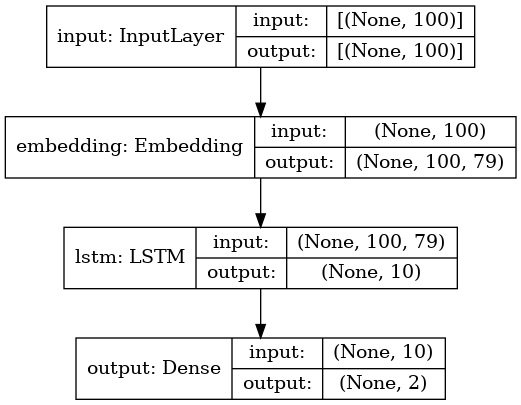

In [4]:
hyperparameters_1 = {
    'pX': X_train['normalize_comment'], 
    'py': y_train, 
    'pnum_words': None, 
    'pseq_length': None,
    'pno_units': 10, 
    'pdropout': 0.2, 
    'pbatch_size': 32, 
    'pepochs': 10, 
    'psave_weights': './models/lstm_model_comments_1.h5'
}

model_1 = DeepModel.SentimentLSTM()
model_1.define(**hyperparameters_1)
model_1.model.summary()
plot_model(model_1.model, to_file='./images/lstm_model_comments_1.png', show_shapes=True, show_layer_names=True)

B√¢y gi·ªù ta ti·∫øn h√†nh training model.

In [5]:
model_1.fit(**hyperparameters_1)

Epoch 1/10
320/320 [==============================] - 31s 86ms/step - loss: 0.4508 - accuracy: 0.8185 - val_loss: 0.3506 - val_accuracy: 0.8549
Epoch 2/10
320/320 [==============================] - 28s 86ms/step - loss: 0.2847 - accuracy: 0.8943 - val_loss: 0.3400 - val_accuracy: 0.8558
Epoch 3/10
320/320 [==============================] - 26s 80ms/step - loss: 0.2424 - accuracy: 0.9119 - val_loss: 0.3460 - val_accuracy: 0.8681
Epoch 4/10
320/320 [==============================] - 25s 79ms/step - loss: 0.2164 - accuracy: 0.9212 - val_loss: 0.3432 - val_accuracy: 0.8663
Epoch 5/10
320/320 [==============================] - 26s 80ms/step - loss: 0.1960 - accuracy: 0.9278 - val_loss: 0.3669 - val_accuracy: 0.8584
Epoch 6/10
320/320 [==============================] - 26s 82ms/step - loss: 0.1812 - accuracy: 0.9369 - val_loss: 0.3840 - val_accuracy: 0.8593
Epoch 7/10
320/320 [==============================] - 14s 44ms/step - loss: 0.1814 - accuracy: 0.9343 - val_loss: 0.3922 - val_accuracy:

In [6]:
!tensorboard --logdir ./tb_log_sentiment --port 6006

2021-10-29 22:18:10.219562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-29 22:18:10.219585: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-29 22:18:11.176327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 22:18:11.176710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-29 22:18:11.176770: W tensorflow

![](./images/12.png)

> **Nh·∫≠n x√©t**:
> * Hai bi·ªÉu ƒë·ªì tr√™n l·∫ßn l∆∞·ª£t th·ªÉ hi·ªán gi√° tr·ªã accuracy v√† loss value qua 10 epoch v·ªõi ƒë∆∞·ªùng m√†u xanh l√† c·ªßa **validation data** v√† h·ªìng l√† c·ªßa **training data** ƒë∆∞·ª£c v·∫Ω b·∫±ng TensorBoard. C√≥ th·ªÉ th·∫•y k·ªÉ t·ª´ epoch th·ª© 2 tr·ªü ƒëi th√¨ loss value c√≥ xu h∆∞·ªõng ƒëi xu·ªëng ·ªü training data v√† ƒëi l√™n ·ªü valudation. L√∫c n√†y nh·ªù c∆° th·∫ø CheckPoint c·ªßa TensorFlow m√† c√°c weight t·∫°i th·ªùi ƒëi·ªÉm n√†y ƒë∆∞·ª£c l∆∞u l·∫°i v√† ta c√≥ th·ªÉ ki·ªÉm tra sau n√†y.

Ti·∫øp theo, ta s·∫Ω tokenizer cho test data ƒë·ªÉ ti·∫øn h√†nh ƒë√°nh gi√° tr√™n test data.

In [7]:
prediction_1 = model_1.predict(X_test['normalize_comment'])
prediction_1

input  \
0     baÃÅn haÃÄng kiÃâ quaÃÇÃÅn ƒëaÃÇÃÄy ƒëuÃâ chaÃÇÃÅt luÃõoÃõÃ£n...   
1     ƒëaÃ£ÃÜt xl aÃÅo ghi xl nhuÃõng beÃÅ tiÃÅ teÃ£o ngang ...   
2     keÃ£p raÃÇÃÅt raÃÇÃÅt ƒëeÃ£p saÃÜn ƒëuÃõoÃõÃ£c giaÃÅ sale h...   
3     khoÃÇng nghiÃÉ aÃÅo ƒëeÃ£p giao haÃÄng nhanh khoÃÇng ...   
4     hoÃÇm nay moÃõÃÅi nhaÃ£ÃÇn ƒëuÃõoÃõÃ£c nhuÃõng nhiÃÄn qua...   
...                                                 ...   
2837  ƒëaÃ£ÃÜt daÃÇy buoÃ£ÃÇc toÃÅc nhuÃõng chiÃâ nhaÃ£ÃÇn ƒëuÃõo...   
2838  chaÃÇÃÅt vaÃâi ƒëeÃ£p coÃÅ veÃâ maÃÅt giao haÃÄng nhanh...   
2839  daÃÇy nhiÃÄn taÃ£m khoÃÇng ƒëeÃ£p maÃÜÃÅc sai daÃÇy pha...   
2840  quaÃÇÃÄn ƒëeÃ£p chaÃÇÃÅt luÃõoÃõÃ£ng ok nhuÃõng chuÃõÃÉ cu...   
2841                                 ok hoÃõi chaÃ£ÃÇt tiÃÅ   

                     output_proba  output_class  
0       (4.148319e-06, 0.9999958)             1  
1        (0.9960705, 0.003929518)             0  
2          (0.809507, 0.19049297)             0  
3         (0.22817881, 0.7718212)             1  
4     (0.99997556, 2.4480925e-05)             0  
...                           ...           ...  
2837   (0.9999796, 2.0352623e-05)             0  
2838   (0.0008592206, 0.99914074)             1  
2839    (0.9999949, 5.076978e-06)             0  
2840     (0.9882366, 0.011763366)             0  
2841    (0.0049098604, 0.9950901)             1  

[2842 rows x 3 columns]

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      1410
    Positive       0.87      0.87      0.87      1432

    accuracy                           0.87      2842
   macro avg       0.87      0.87      0.87      2842
weighted avg       0.87      0.87      0.87      2842



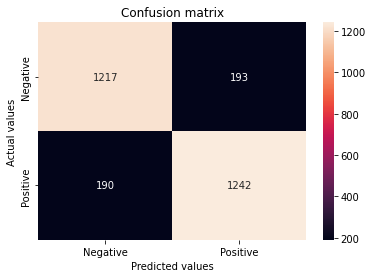

In [8]:
Model.confusionMatrix(y_test, prediction_1['output_class'])

> **Nh·∫≠n x√©t**:
> * Ta c√≥ th·ªÉ th·∫•y r√µ r√†ng r·∫±ng d√π ƒë·ªô ch√≠nh x√°c c·ªßa model LSTM kh√° cao h∆°n 85%, v·ªõi vi·ªác ƒë·ªÉ c√°c hyper-params cho TensorFlow t·ª± quy·∫øt th√¨ model c√≥ kh·∫£ nƒÉng d·ª± ƒëo√°n c√¢n b·∫±ng tr√™n c·∫£ hai class l√† negative v√† postive, ta kh√¥ng c·∫ßn ph·∫£i ki·ªÉm tra l·∫°i b·∫±ng ROC-AUC.

Do ta c√≥ √°p d·ª•ng checkpoint trong model ƒë·ªÉ l∆∞u l·∫°i c√°c b·ªô tham s·ªë t·ªët nh·∫•t trong qu√° tr√¨nh training, ta c√≥ th·ªÉ l·∫•y b·ªô tham s·ªë m√† c√≥ validation loss th·∫•p nh·∫•t ƒë·ªÉ update tr·ªçng s·ªë cho model.

In [9]:
model_uw_1 = DeepModel.SentimentLSTM()
model_uw_1.define(**hyperparameters_1)
model_uw_1.model.load_weights("./models/lstm_model_comments_1/weights/02-0.340042.h5")

In [10]:
prediction_uw_1 = model_uw_1.predict(X_test['normalize_comment'])
prediction_uw_1

input  \
0     baÃÅn haÃÄng kiÃâ quaÃÇÃÅn ƒëaÃÇÃÄy ƒëuÃâ chaÃÇÃÅt luÃõoÃõÃ£n...   
1     ƒëaÃ£ÃÜt xl aÃÅo ghi xl nhuÃõng beÃÅ tiÃÅ teÃ£o ngang ...   
2     keÃ£p raÃÇÃÅt raÃÇÃÅt ƒëeÃ£p saÃÜn ƒëuÃõoÃõÃ£c giaÃÅ sale h...   
3     khoÃÇng nghiÃÉ aÃÅo ƒëeÃ£p giao haÃÄng nhanh khoÃÇng ...   
4     hoÃÇm nay moÃõÃÅi nhaÃ£ÃÇn ƒëuÃõoÃõÃ£c nhuÃõng nhiÃÄn qua...   
...                                                 ...   
2837  ƒëaÃ£ÃÜt daÃÇy buoÃ£ÃÇc toÃÅc nhuÃõng chiÃâ nhaÃ£ÃÇn ƒëuÃõo...   
2838  chaÃÇÃÅt vaÃâi ƒëeÃ£p coÃÅ veÃâ maÃÅt giao haÃÄng nhanh...   
2839  daÃÇy nhiÃÄn taÃ£m khoÃÇng ƒëeÃ£p maÃÜÃÅc sai daÃÇy pha...   
2840  quaÃÇÃÄn ƒëeÃ£p chaÃÇÃÅt luÃõoÃõÃ£ng ok nhuÃõng chuÃõÃÉ cu...   
2841                                 ok hoÃõi chaÃ£ÃÇt tiÃÅ   

                     output_proba  output_class  
0     (0.00073411025, 0.99926585)             1  
1        (0.9971385, 0.002861474)             0  
2        (0.9313881, 0.068611994)             0  
3        (0.011878509, 0.9881215)             1  
4        (0.9889897, 0.011010231)             0  
...                           ...           ...  
2837    (0.9959667, 0.0040333555)             0  
2838     (0.010884253, 0.9891158)             1  
2839    (0.99751866, 0.002481401)             0  
2840     (0.91258466, 0.08741527)             0  
2841      (0.23734112, 0.7626589)             1  

[2842 rows x 3 columns]

              precision    recall  f1-score   support

    Negative       0.85      0.90      0.87      1410
    Positive       0.89      0.84      0.87      1432

    accuracy                           0.87      2842
   macro avg       0.87      0.87      0.87      2842
weighted avg       0.87      0.87      0.87      2842



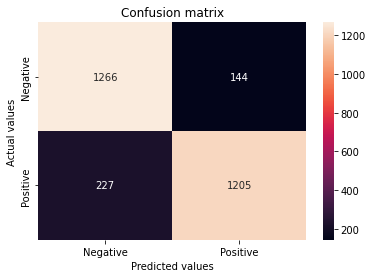

In [11]:
Model.confusionMatrix(y_test, prediction_uw_1['output_class'])

> **Nh·∫≠n x√©t**:
> * Ta th·∫•y r·∫±ng n·∫øu nh√¨n v√†o c√°c ch·ªâ s·ªë nh∆∞ **precision**, **recall** v√† **F1-score** th√¨ model ƒë∆∞·ª£c update b·ªüi weight ·ªü t·∫°i epoch th·ª© hai n√†y ho·∫°t ƒë·ªông cho hi·ªáu su·∫•t th·∫≠m ch√≠ t·ªët h∆°n m·ªôt √≠t d√π ch·ªâ m·ªõi tr·∫£i qua 2 epoch.

Ta s·∫Ω ƒë√†o t·∫°o m·ªôt model th·ª© hai v·ªõi c√°c hyper-params l√† `num_word` v√† `maxlen` l·∫ßn l∆∞·ª£t l√† 3000 v√† 100, ·ªü project hai ta ƒë√£ t√≠nh ƒë∆∞·ª£c to√†n b·ªô data c·ªßa ta c√≥ kho·∫£ng loanh quanh 3000 t·ª´ v√† c√°c comment hay c√≥ ƒë·ªô d√†i l√† 100 v√† s·ª≠ d·ª•ng 15 neuron ·ªü LSTM layer.

Ta s·∫Ω ƒë·ªãnh nghƒ©a model sau ƒë√≥ cho training, d·ª± ƒëo√°n v√† ƒë√°nh gi√°.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          358500    
_________________________________________________________________
lstm (LSTM)                  (None, 15)                6960      
_________________________________________________________________
output (Dense)               (None, 2)                 32        
Total params: 365,492
Trainable params: 365,492
Non-trainable params: 0
_________________________________________________________________


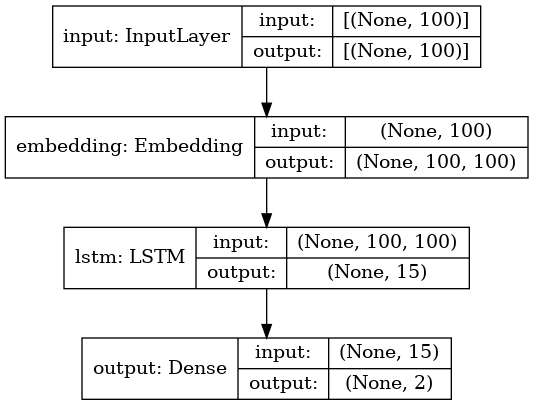

In [12]:
hyperparameters_2 = {
    'pX': X_train['normalize_comment'], 
    'py': y_train, 
    'pnum_words': 3000, 
    'pseq_length': 100,
    'pno_units': 15, 
    'pdropout': 0.3, 
    'pbatch_size': 32, 
    'pepochs': 10, 
    'psave_weights': './models/lstm_model_comments_2.h5'
}

model_2 = DeepModel.SentimentLSTM()
model_2.define(**hyperparameters_2)
model_2.model.summary()
plot_model(model_2.model, to_file='./images/lstm_model_comments_2.png', show_shapes=True, show_layer_names=True)

In [13]:
model_2.fit(**hyperparameters_2)

Epoch 1/10
320/320 [==============================] - 29s 81ms/step - loss: 0.4130 - accuracy: 0.8312 - val_loss: 0.3323 - val_accuracy: 0.8602
Epoch 2/10
320/320 [==============================] - 25s 79ms/step - loss: 0.2828 - accuracy: 0.8889 - val_loss: 0.3205 - val_accuracy: 0.8716
Epoch 3/10
320/320 [==============================] - 25s 77ms/step - loss: 0.2386 - accuracy: 0.9107 - val_loss: 0.3210 - val_accuracy: 0.8725
Epoch 4/10
320/320 [==============================] - 24s 76ms/step - loss: 0.2124 - accuracy: 0.9209 - val_loss: 0.3401 - val_accuracy: 0.8707
Epoch 5/10
320/320 [==============================] - 25s 77ms/step - loss: 0.1907 - accuracy: 0.9298 - val_loss: 0.3552 - val_accuracy: 0.8654
Epoch 6/10
320/320 [==============================] - 24s 74ms/step - loss: 0.1752 - accuracy: 0.9363 - val_loss: 0.3658 - val_accuracy: 0.8646
Epoch 7/10
320/320 [==============================] - 23s 72ms/step - loss: 0.1636 - accuracy: 0.9390 - val_loss: 0.3769 - val_accuracy:

In [14]:
!tensorboard --logdir ./tb_log_sentiment --port 6006

2021-10-29 22:24:59.870715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-29 22:24:59.870745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-29 22:25:01.069888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 22:25:01.070465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-10-29 22:25:01.070563: W tensorflow

![](./images/13.png)

> **Nh·∫≠n x√©t**:
> * V·ªõi vi·ªác ta t·ª± ƒë·ªãnh nghƒ©a hyper-params set, k·∫øt qu·∫£ ƒëem l·∫°i kh√¥ng t·ªët h∆°n so v·ªõi model 1. C√≥ th·ªÉ th·∫•y r√µ accuracy v√† loss validation tr√™n training data (ƒë∆∞·ªùng m√†u x√°m) v√† validation data (ƒë∆∞·ªùng m√†u cam) b·∫Øt ƒë·∫ßu kh√°c nhau v√† kho·∫£ng c√°ch kh√°c bi·ªát l√† l·ªõn - kh√¥ng ƒë∆∞·ª£c ·ªïn ƒë·ªãnh b·∫±ng model 1.
> * Ta c√≥ th·ªÉ update weight t·∫°i epocg th·ª© 2 xem c√≥ c·∫£i thi·ªán h∆°n kh√¥ng.

In [15]:
prediction_2 = model_2.predict(X_test['normalize_comment'])
prediction_2

input  \
0     baÃÅn haÃÄng kiÃâ quaÃÇÃÅn ƒëaÃÇÃÄy ƒëuÃâ chaÃÇÃÅt luÃõoÃõÃ£n...   
1     ƒëaÃ£ÃÜt xl aÃÅo ghi xl nhuÃõng beÃÅ tiÃÅ teÃ£o ngang ...   
2     keÃ£p raÃÇÃÅt raÃÇÃÅt ƒëeÃ£p saÃÜn ƒëuÃõoÃõÃ£c giaÃÅ sale h...   
3     khoÃÇng nghiÃÉ aÃÅo ƒëeÃ£p giao haÃÄng nhanh khoÃÇng ...   
4     hoÃÇm nay moÃõÃÅi nhaÃ£ÃÇn ƒëuÃõoÃõÃ£c nhuÃõng nhiÃÄn qua...   
...                                                 ...   
2837  ƒëaÃ£ÃÜt daÃÇy buoÃ£ÃÇc toÃÅc nhuÃõng chiÃâ nhaÃ£ÃÇn ƒëuÃõo...   
2838  chaÃÇÃÅt vaÃâi ƒëeÃ£p coÃÅ veÃâ maÃÅt giao haÃÄng nhanh...   
2839  daÃÇy nhiÃÄn taÃ£m khoÃÇng ƒëeÃ£p maÃÜÃÅc sai daÃÇy pha...   
2840  quaÃÇÃÄn ƒëeÃ£p chaÃÇÃÅt luÃõoÃõÃ£ng ok nhuÃõng chuÃõÃÉ cu...   
2841                                 ok hoÃõi chaÃ£ÃÇt tiÃÅ   

                     output_proba  output_class  
0      (7.5561167e-07, 0.9999993)             1  
1        (0.92751795, 0.07248204)             0  
2         (0.07028565, 0.9297143)             1  
3         (0.13486566, 0.8651343)             1  
4      (0.9999882, 1.1852359e-05)             0  
...                           ...           ...  
2837   (0.9999896, 1.0315402e-05)             0  
2838  (0.00067545846, 0.99932456)             1  
2839      (0.99999, 1.001526e-05)             0  
2840      (0.981992, 0.018007934)             0  
2841   (0.0009869847, 0.99901295)             1  

[2842 rows x 3 columns]

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      1410
    Positive       0.86      0.86      0.86      1432

    accuracy                           0.86      2842
   macro avg       0.86      0.86      0.86      2842
weighted avg       0.86      0.86      0.86      2842



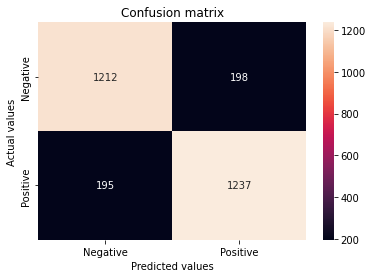

In [16]:
Model.confusionMatrix(y_test, prediction_2['output_class'])

> **Nh·∫≠n x√©t**:
> * ƒê·ªô ch√≠nh x√°c c·ªßa model 2 n√†y l√† 86 ph·∫ßn trƒÉm.
> * Nh∆∞ng ta n√™n ƒë·∫∑t c√¢u h·ªèi v√¨ sao ƒë√£ qua 2 model c√≥ ki·∫øn tr√∫c kh√°c nhau r·∫•t nhi·ªÅu nh∆∞ng ƒë·ªô ch√≠nh x√°c v·∫´n loanh quanh 86, 87%.

In [17]:
model_uw_2 = DeepModel.SentimentLSTM()
model_uw_2.define(**hyperparameters_2)
model_uw_2.model.load_weights("./models/lstm_model_comments_2/weights/02-0.320474.h5")

In [18]:
prediction_uw_2 = model_uw_2.predict(X_test['normalize_comment'])
prediction_uw_2

input  \
0     baÃÅn haÃÄng kiÃâ quaÃÇÃÅn ƒëaÃÇÃÄy ƒëuÃâ chaÃÇÃÅt luÃõoÃõÃ£n...   
1     ƒëaÃ£ÃÜt xl aÃÅo ghi xl nhuÃõng beÃÅ tiÃÅ teÃ£o ngang ...   
2     keÃ£p raÃÇÃÅt raÃÇÃÅt ƒëeÃ£p saÃÜn ƒëuÃõoÃõÃ£c giaÃÅ sale h...   
3     khoÃÇng nghiÃÉ aÃÅo ƒëeÃ£p giao haÃÄng nhanh khoÃÇng ...   
4     hoÃÇm nay moÃõÃÅi nhaÃ£ÃÇn ƒëuÃõoÃõÃ£c nhuÃõng nhiÃÄn qua...   
...                                                 ...   
2837  ƒëaÃ£ÃÜt daÃÇy buoÃ£ÃÇc toÃÅc nhuÃõng chiÃâ nhaÃ£ÃÇn ƒëuÃõo...   
2838  chaÃÇÃÅt vaÃâi ƒëeÃ£p coÃÅ veÃâ maÃÅt giao haÃÄng nhanh...   
2839  daÃÇy nhiÃÄn taÃ£m khoÃÇng ƒëeÃ£p maÃÜÃÅc sai daÃÇy pha...   
2840  quaÃÇÃÄn ƒëeÃ£p chaÃÇÃÅt luÃõoÃõÃ£ng ok nhuÃõng chuÃõÃÉ cu...   
2841                                 ok hoÃõi chaÃ£ÃÇt tiÃÅ   

                     output_proba  output_class  
0     (0.00043627014, 0.99956375)             1  
1        (0.9958728, 0.004127209)             0  
2          (0.115075, 0.88492507)             1  
3        (0.012311526, 0.9876885)             1  
4         (0.8120184, 0.18798164)             0  
...                           ...           ...  
2837     (0.997141, 0.0028590155)             0  
2838   (0.0035439562, 0.99645597)             1  
2839    (0.99527293, 0.004727039)             0  
2840      (0.74641526, 0.2535847)             0  
2841      (0.1930916, 0.80690837)             1  

[2842 rows x 3 columns]

              precision    recall  f1-score   support

    Negative       0.86      0.89      0.88      1410
    Positive       0.89      0.86      0.87      1432

    accuracy                           0.87      2842
   macro avg       0.88      0.87      0.87      2842
weighted avg       0.88      0.87      0.87      2842



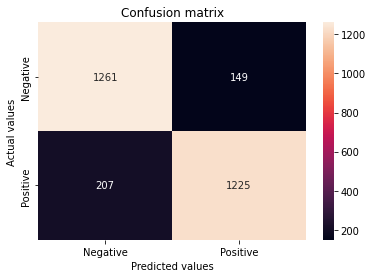

In [19]:
Model.confusionMatrix(y_test, prediction_uw_2['output_class'])

> **Nh·∫≠n x√©t**:
> * ƒê·ªô ch√≠nh x√°c l√∫c n√†y 87%.
> * N·∫øu ta ƒë√†o t·∫°o qu√° 10 epoch th√¨ c√†ng ng√†ng b·ªã overfitting, nh∆∞ng n·∫øu ta thay ƒë·ªïi ki·∫øn tr√∫c c·ªßa model th√¨ ƒë·ªô ch√≠nh x√°c lu√¥n loanh quanh 86, 87%. Nh∆∞ v·∫≠y ƒë√¢y c√≥ ph·∫£i l√† ƒë·ªô ch√≠nh x√°c t·ªëi ƒëa m√† model LSTM c√≥ th·ªÉ ƒë·∫°t ƒë∆∞·ª£c ho·∫∑c l√† do ch√≠nh data c·ªßa ta b·ªã variance error do c√≥ s·ª± ch·ªìng ch√©o data gi·ªØa nagative v√† postive ·ªü c√°c comment 3 sao.

B√¢y gi·ªù ta s·∫Ω l∆∞u l·∫°i c√°c model n√†y th√†nh file `*.h5` v√† c√°c vectorizer t∆∞∆°ng ·ª©ng th√†nh file `*.pickle`.

In [21]:
model_1.save("./models/lstm_model_comments_1/lstm_model_comments_1.h5", "./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle")
model_uw_1.save("./models/lstm_model_comments_1/lstm_model_comments_uw_1.h5", "./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle")

<keras_preprocessing.text.Tokenizer object at 0x7f4d3aa8a460> has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle.
üì¢ Model has been saved at ./models/lstm_model_comments_1/lstm_model_comments_1.h5 - Tokenizer has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_1.pickle.
<keras_preprocessing.text.Tokenizer object at 0x7f4d3ae7a430> has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle.
üì¢ Model has been saved at ./models/lstm_model_comments_1/lstm_model_comments_uw_1.h5 - Tokenizer has been saved at ./models/lstm_model_comments_1/lstm_tokenizer_comments_uw_1.pickle.


In [22]:
model_2.save("./models/lstm_model_comments_2/lstm_model_comments_2.h5", "./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle")
model_uw_2.save("./models/lstm_model_comments_2/lstm_model_comments_uw_2.h5", "./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle")

<keras_preprocessing.text.Tokenizer object at 0x7f4e093d01f0> has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle.
üì¢ Model has been saved at ./models/lstm_model_comments_2/lstm_model_comments_2.h5 - Tokenizer has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_2.pickle.
<keras_preprocessing.text.Tokenizer object at 0x7f4e09444cd0> has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle.
üì¢ Model has been saved at ./models/lstm_model_comments_2/lstm_model_comments_uw_2.h5 - Tokenizer has been saved at ./models/lstm_model_comments_2/lstm_tokenizer_comments_uw_2.pickle.


B√¢y gi·ªù ch√∫ng ta s·∫Ω ti·∫øn h√†nh Hyper Parameters b·∫±ng ph∆∞∆°ng ph√°p HyperBand ƒë∆∞·ª£c ƒë·ªÅ xu·∫•t v√†o nƒÉm 2016. ƒê√¢y l√† b√†i b√°o ƒë√≥ [https://arxiv.org/pdf/1603.06560.pdf](https://arxiv.org/pdf/1603.06560.pdf). √ù t∆∞·ªüng c·ªßa ph∆∞∆°ng ph√°p n√†y l√† HyperBand s·∫Ω random ra m·ªôt v√†i hyper-params set ban ƒë·∫ßu. Ti·∫øp theo n√≥ s·∫Ω ti·∫øn h√†nh ƒë√†o t·∫°o c√°c model n√†y v√† th·ª±c hi·∫øn ƒë√°nh gi√° d·ª±a tr√™n loss value c·ªßa train ho·∫∑c test do ta quy ƒë·ªãnh. Ti·∫øp theo n√≥ s·∫Ω ti·∫øn h√†nh ch·ªçn l·ªçc d·ª±a tr√™n c√°c c√¥ng th·ª©c ƒë·ªÉ ch·ªçn ra c√°c hyperparam set c√≥ loss th·∫•p nh·∫•t v√† lo·∫°i b·ªè ƒëi c√°c hyperparams set cho hi·ªáu su·∫•t k√©m. V·ªõi t·ª´ng hyperparams set ƒë∆∞·ª£c ch·ªçn l·ªçc n√†y n√≥ s·∫Ω ƒë√†o t·∫°o l·∫°i v√† ti·∫øp t·ª•c lo·∫°i b·ªè v√† ƒë√†o t·∫°o l·∫°i cho ƒë·∫øn khi c√≤n l·∫°i model t·ªët nh·∫•t.

B√†i vi·∫øt g·ªëc c·ªßa t√°c gi·∫£ ƒë·ªçc s·∫Ω kh√≥ hi·ªÉu v√† n·∫∑ng v·ªÅ to√°n h·ªçc, n√™n ta c√≥ th·ªÉ ƒë·ªçc t·∫°i ƒë√¢y ƒë·ªÉ d·ªÖ hi·ªÉu h∆°n [https://medium.com/data-from-the-trenches/a-slightly-better-budget-allocation-for-hyperband-bbd45af14481](https://medium.com/data-from-the-trenches/a-slightly-better-budget-allocation-for-hyperband-bbd45af14481).

B√¢y gi·ªù ta s·∫Ω t·∫°o m·ªôt h√†m `get_params()` l√† m·ªôt Random-Search ra m·ªôt hyperparam-set. Ti·∫øp theo h√†m `try_params()` s·∫Ω nh·∫≠n v√†o hyperparam set ph√°t sinh t·ª´ `get_params()` v√† ti·∫øn h√†nh training. Hai h√†m n√†y s·∫Ω ƒë∆∞·ª£c b·ªè v√†o m·ªôt object `Hyperband` nh∆∞ l√† c√°c tham s·ªë, l√† object n√†y s·∫Ω th·ª±c hi·ªán t√≠nh to√°n v√† tr·∫£ ra hyperparams set t·ªët nh·∫•t.

In [26]:
def get_params():
    pbatch_size = np.random.choice(np.arange(5, 100, 10))
    pnum_words = np.random.choice(np.arange(2000, 3000, 10))
    optimizers = np.random.choice(['rmsprop', 'adam', 'adadelta'])
    pdropout = np.random.choice(np.linspace(0.1, 0.5, 10))
    pno_units = np.random.choice(np.arange(10, 50, 10))
    pseq_length = np.random.choice(np.arange(50, 200, 10))
    
    return {
        'pX': X_train['normalize_comment'], 
        'py': y_train, 
        'pnum_words': pnum_words, 
        'pseq_length': pseq_length,
        'pno_units': pno_units, 
        'pdropout': pdropout, 
        'poptimizers': optimizers,
        'pbatch_size': pbatch_size, 
        'pepochs': 10, 
        'psave_weights': './models/lstm_model_comments_3.h5'
    }

In [27]:
def try_params(**kwargs):
    model = DeepModel.SentimentLSTM()
    model.define(**kwargs)
    model.fit(**kwargs)

    return {"loss": model.evaluation()}

In [28]:
hb = DeepModel.Hyperband(get_params, try_params)
results = hb.run()

print(results)


*** 81 configurations x 1.0 iterations each

1 | Fri Oct 29 19:48:53 2021 | lowest loss so far: inf (run -1)

Epoch 1/10
137/137 [==============================] - 17s 108ms/step - loss: 0.5406 - accuracy: 0.7995 - val_loss: 0.4038 - val_accuracy: 0.8461
Epoch 2/10
137/137 [==============================] - 15s 106ms/step - loss: 0.3273 - accuracy: 0.8843 - val_loss: 0.3485 - val_accuracy: 0.8637
Epoch 3/10
137/137 [==============================] - 15s 113ms/step - loss: 0.2686 - accuracy: 0.9052 - val_loss: 0.3341 - val_accuracy: 0.8619
Epoch 4/10
137/137 [==============================] - 16s 113ms/step - loss: 0.2398 - accuracy: 0.9155 - val_loss: 0.3449 - val_accuracy: 0.8628
Epoch 5/10
137/137 [==============================] - 16s 115ms/step - loss: 0.2176 - accuracy: 0.9246 - val_loss: 0.3456 - val_accuracy: 0.8637
Epoch 6/10
137/137 [==============================] - 16s 113ms/step - loss: 0.2084 - accuracy: 0.9256 - val_loss: 0.3573 - val_accuracy: 0.8619
Epoch 7/10
137/137 

> **Nh·∫≠n x√©t**:
> * ·ªû ƒë√¢y nh√≥m ƒë√£ ti·∫øn h√†nh ng·∫Øt qu√° tr√¨nh ƒë√†o t·∫°o l·∫°i, h√¨nh d∆∞·ªõi ƒë√¢y ƒë∆∞·ª£c ch·ª•p t·ª´ file `hyperband.txt` - file n√†y ghi l·∫°i l·ªãch s·ª≠ c·ªßa qu√° tr√¨nh optimization, ta th·∫•y r·∫±ng:
> ![](./images/17.png)
>   * D√π tr·∫£i qua 20 l·∫ßn ƒë√†o t·∫°o l·∫°i c√°c model d·ª±a tr√™n c√°c hyperparam-set kh√°c nhau cho validation loss th·∫•p nh·∫•t, nh∆∞ng gi√° tr·ªã n√†y v·∫´n l·ªõn h∆°n 0.3 t∆∞∆°ng t·ª± nh∆∞ `model_1` v√† `model_2` m√† ta ƒë√†o t·∫°o ban ƒë·∫ßu, xem ra ƒë√¢y c√≥ th·ªÉ l√† hi·ªáu su·∫•t t·ªët nh·∫•t m√† model LSTM c·ªßa ta c√≥ th·ªÉ l√†m ƒë∆∞·ª£c. 
>   * T·ª´ ƒë√¢y g√≥p ph·∫ßn cho ta ch·∫Øc ch·∫Øn h∆°n r·∫±ng dataset comments c·ªßa ch√∫ng ta ƒëang th·ª±c s·ª± b·ªã variance error.